In [1]:
import numpy as np
from scipy.linalg import eigh
from viga import Viga
import plotfrecs as pf
import pdb
import matplotlib.pyplot as plt
import mefmods as mef
plt.style.use('default')
plt.rc('figure', figsize=(12,8))
plt.rc('font', size=22)
modo = 'trans'
modo_name = 'Transversal'
glxn = 2
#interpolators = [mef.NL1DA, mef.NL1DB]
interpolators = [mef.NT1, mef.NT2, mef.NT3, mef.NT4]

Iniciamos el objeto Viga.

In [2]:
V = Viga(1, 210e9, 10e-4, 7850, 10e-8)
#V.mesh(3, 'long')

In [3]:
# Estudio de convergencia, modos transversales lump vs consistentes
maxmode = 6
nmax = 15
w_cons, d_cons = V.converge_study(nmax, maxmode, modo)
# solucion de muchos modos

In [4]:
V.MN.shape

(16, 2)

In [5]:
V.mesh(100, modo)
wv, dv = V.solvemods(V.K, V.M)

In [6]:
# dv = dv[::2, :] / dv[-2, :]
xv = np.linspace(0, 1, 101)
w_lump, d_lump = V.converge_study(nmax, maxmode,  modo+'_lump')

In [7]:
MODES = [d_cons, d_lump]
labels=('consistentes', 'concentradadas')

In [8]:
import matplotlib.lines as mlines

In [9]:
modes = [1,2,3,4]

In [10]:
x, y, xx, yy = V.InterpolateAllElements(d_cons, modes, interpolators=interpolators, _glxn= glxn)

Text(0.5, 1.05, 'masas consistentes')

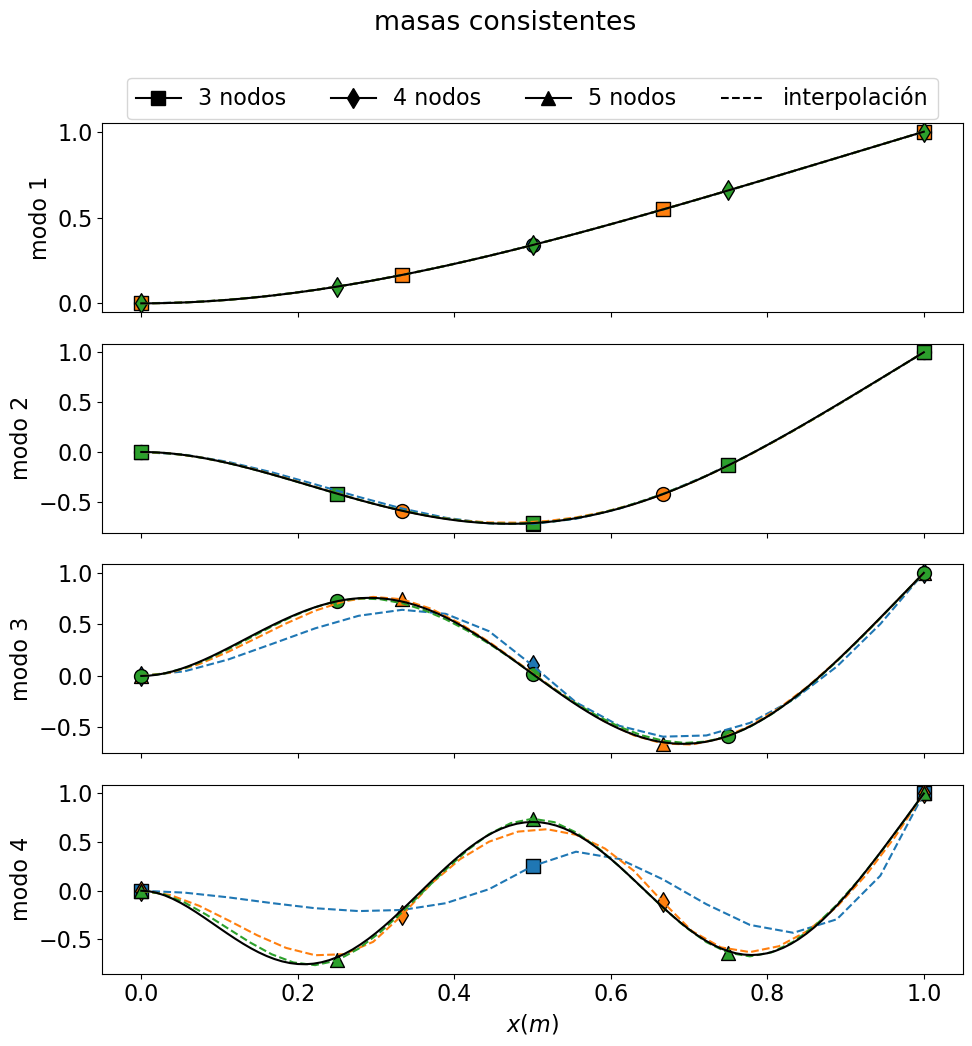

In [11]:
fig, ax = V.plot_modes(modes, x,y,xx,yy)
for m, tax in enumerate(ax):
    axes = tax.plot(xv, dv[::glxn,m]/dv[-glxn,m], 'k')
fig.suptitle('masas consistentes', y=1.05)


In [12]:
xt, yt, xxt, yyt = V.InterpolateAllElements(d_lump, modes, interpolators=interpolators, _glxn= glxn)

Text(0.5, 1.05, 'masas concentradas')

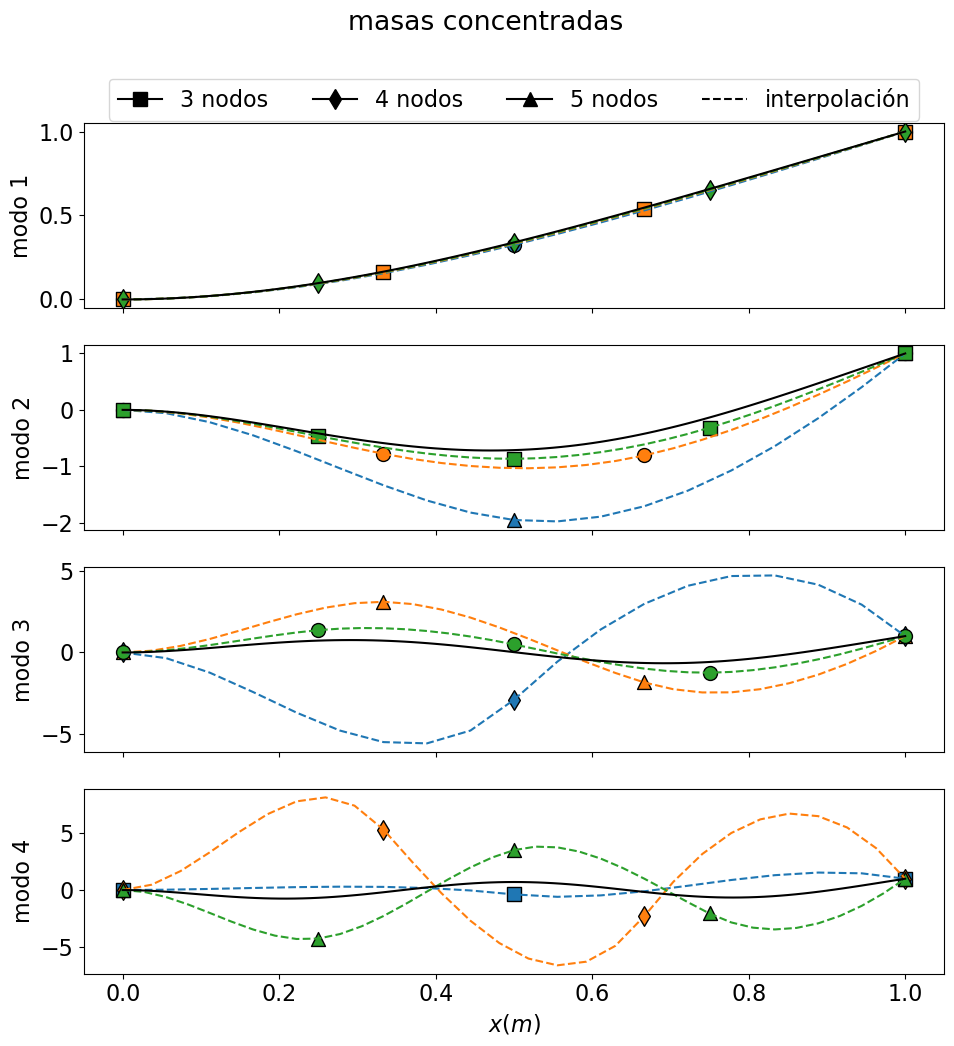

In [13]:
fig, ax = V.plot_modes(modes, xt,yt,xxt,yyt)
fig.suptitle
for m, tax in enumerate(ax):
    tax.plot(xv, dv[::glxn,m]/dv[-glxn,m], 'k')
fig.suptitle('masas concentradas', y=1.05)

/home/mariano/modelizacion/SolucionesProblemas/Guia4-MEF-dt/Guia4-python/Ejercicio1/plotfrecs.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lin,
/home/mariano/modelizacion/SolucionesProblemas/Guia4-MEF-dt/Guia4-python/Ejercicio1/plotfrecs.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


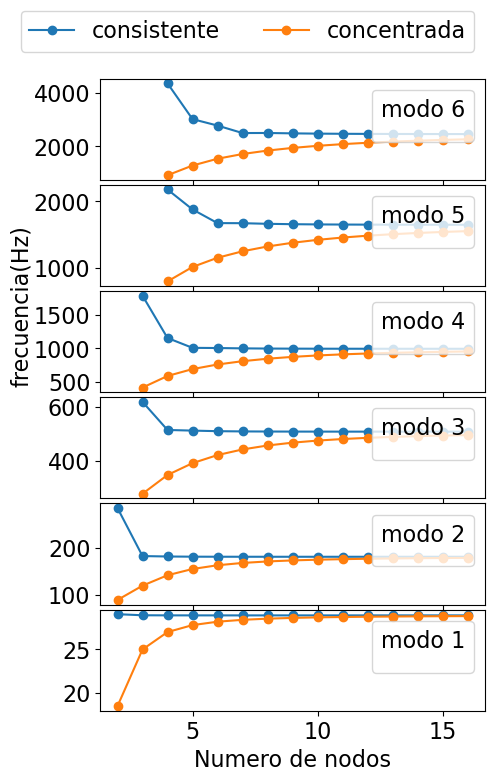

In [14]:
ws = [w_cons, w_lump]
cases = ['consistente', 'concentrada']
name='transversal'
pf.plotfrecs(ws, cases, name)

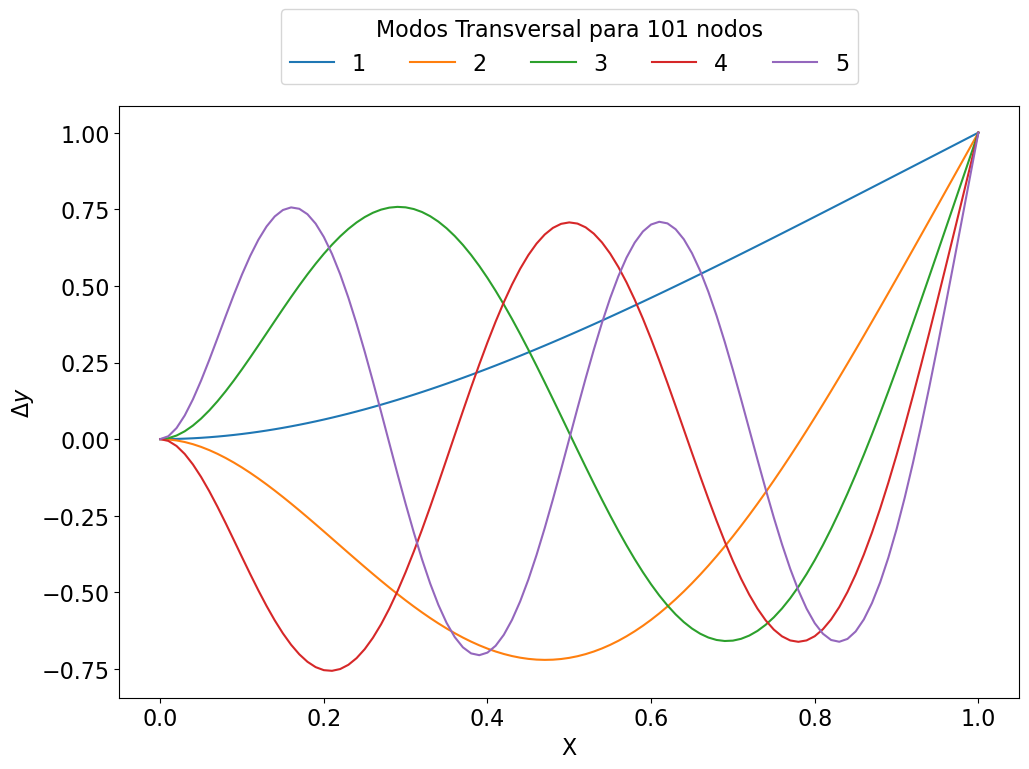

In [15]:
# los primeros 5 modos trans
fig, ax = pf.allmodesplot(dv[:,:5], modo_name, fig_size=(4, 10))

# Animate in gmsh 

In [16]:
V.mesh(100, modo)
wv, dv = V.solvemods(V.K, V.M)

In [17]:
import gmsh

In [23]:
for imodo in [1,2,3,4,5]:
    gmsh.initialize()
    modelname = 'ModosTransversales'
    thismodel = gmsh.model.add(modelname)
    nodetags = np.linspace(1, len(V.MN), len(V.MN)).astype(int)
    MN = np.hstack([V.MN, np.zeros([len(V.MN), 1])])
    elementtags = np.linspace(1, len(V.MC)+1, len(V.MC)).astype(int)
    zeros = np.zeros((len(nodetags), 1))
    Points = []
    Points.append(gmsh.model.geo.addPoint(*np.append(MN[0],[1])))
    Points.append(gmsh.model.geo.addPoint(*np.append(MN[-1],[1])))
    L = gmsh.model.geo.addLine(*Points)
    gmsh.model.geo.synchronize()
    group = gmsh.model.addPhysicalGroup(1, [L])
    gmsh.model.mesh.addNodes(1, L, nodetags, MN.ravel())
    gmsh.model.mesh.addElements(1, L, [1], [elementtags], [V.MC.ravel()+1])
    mode = dv[::glxn,imodo-1].reshape(-1,1)
    omega = wv[imodo-1]
    T = 2*np.pi / (omega)
    ts = np.linspace(0, T, 100)
    #fig,ax = plt.subplots(1,len(ts), figsize=(15,5), sharey=True)
    thisview = gmsh.view.add(f'modo{imodo}')
    for i, t in enumerate(ts[:-1]):
        D = np.hstack([zeros, mode*np.sin(omega*t), zeros])
        gmsh.view.addModelData(
            thisview, i, modelname,'NodeData', nodetags, D, t, numComponents=3 )
    gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
    gmsh.option.setNumber(f"View[{thisview}].LineWidth", 10)
    gmsh.option.setNumber(f'PostProcessing.AnimationDelay', 0.1)
    gmsh.view.write(thisview, f'Modo{imodo}.msh')
    gmsh.finalize()

Info    : Writing 'Modo1.msh'...
Info    : Done writing 'Modo1.msh'
Info    : Writing 'Modo2.msh'...
Info    : Done writing 'Modo2.msh'
Info    : Writing 'Modo3.msh'...
Info    : Done writing 'Modo3.msh'
Info    : Writing 'Modo4.msh'...
Info    : Done writing 'Modo4.msh'
Info    : Writing 'Modo5.msh'...
Info    : Done writing 'Modo5.msh'
